In [1]:
from pathlib import Path
import os, sys
sys.path.append('..')
import torch
import numpy as np
from matplotlib.patches import Circle
from skimage.transform import resize
import copy
import json
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
from IPython.display import clear_output

from model.net import XNMNet
from utils.generate_programs import generate_single_program, load_program_generator
from utils.misc import convert_david_program_to_mine, invert_dict, todevice
from DataLoader import ClevrDataLoader



/home/jiaxin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ckpt = '/data4/jiaxin/exp/CLEVR/cogent_detect_dense/model.pt'
input_dir = '/data4/jiaxin/exp/CLEVR/data_cogent/'
val_question_pt = os.path.join(input_dir, 'valB_questions.pt')
val_feature_pt = os.path.join(input_dir, 'valB_features_salient_thres0.4.pt')
annotation_json = '/data4/CLEVR_CoGenT_v1.0/scenes/CLEVR_valB_scenes.json'
vocab_json = os.path.join(input_dir, 'vocab.json')
pretrained_dir = '../pretrained/'
image_dir = '/data4/CLEVR_CoGenT_v1.0/images/valB/'

orig_annotations = json.load(open(annotation_json))['scenes']
orig_annotations = { int(s['image_index']):s for s in orig_annotations }

loaded = torch.load(ckpt, map_location={'cuda:0': 'cpu'})
model_kwargs = loaded['model_kwargs']
val_loader_kwargs = {
    'question_pt': val_question_pt,
    'feature_pt': val_feature_pt,
    'vocab_json': vocab_json,
    'batch_size': 1,
    'edge_class': model_kwargs.get('edge_class', 'rule'),
    'shuffle': False
}
val_loader = ClevrDataLoader(**val_loader_kwargs)
vocab = val_loader.vocab

model_kwargs.update({'vocab': val_loader.vocab})
model = XNMNet(**model_kwargs).to(device)
model.load_state_dict(loaded['state_dict'])
model.eval()

program_generator = load_program_generator(os.path.join(pretrained_dir, 'program_generator.pt')).to(device)
david_vocab = json.load(open(os.path.join(pretrained_dir, 'david_vocab.json')))
david_vocab['program_idx_to_token'] = invert_dict(david_vocab['program_token_to_idx'])

loading vocab from /data4/jiaxin/exp/CLEVR/data_cogent/vocab.json
loading questions from /data4/jiaxin/exp/CLEVR/data_cogent/valB_questions.pt


In [3]:
def question_to_str(question, vocab):
    question_str = ' '.join(list(filter(
        lambda x: x not in {'<NULL>','<START>','<END>'}, 
        [vocab['question_idx_to_token'][q.item()] for q in question.squeeze()]
    )))
    return question_str

def predict_david_program(questions, data):
    programs, program_inputs = [], []
    # generate program using david model for each question
    for i in range(questions.size(0)):
        question_str = []
        for j in range(questions.size(1)):
            word = data.vocab['question_idx_to_token'][questions[i,j].item()]
            if word == '<START>': continue
            if word == '<END>': break
            question_str.append(word)
        question_str = ' '.join(question_str) # question string
        david_program = generate_single_program(question_str, program_generator, david_vocab, device)
        david_program = [david_vocab['program_idx_to_token'][i.item()] for i in david_program.squeeze()]
        # convert david program to ours. return two index lists
        program, program_input = convert_david_program_to_mine(david_program, data.vocab)
        programs.append(program)
        program_inputs.append(program_input)
    # padding
    max_len = max(len(p) for p in programs)
    for i in range(len(programs)):
        while len(programs[i]) < max_len:
            programs[i].append(vocab['program_token_to_idx']['<NULL>'])
            program_inputs[i].append(vocab['question_token_to_idx']['<NULL>'])
    # to tensor
    programs = torch.LongTensor(programs).to(device)
    program_inputs = torch.LongTensor(program_inputs).to(device)
    return programs, program_inputs

    

def draw_at_coords(ax, coords, attn, img, title, radius=10, target_size=360):
    coords = copy.deepcopy(coords)
    for i in range(len(coords)):
        coords[i] = coords[i][:2]
        # [0,28) -> [0,1], (y,x) -> (x,y)
        coords[i][0] = coords[i][0] / 27 * target_size
        coords[i][1] = coords[i][1] / 27 * target_size
        coords[i] = coords[i][::-1]
    attn = attn[:len(coords)]
    ax.imshow(resize(img, (target_size, target_size)))
    ax.axis('off')
    ax.set_title(title, fontsize=20)
    for coord, a in zip(coords, attn):
        a = min(max(a, 0), 1)
        patch = Circle(coord, radius, color=(1,1-a,1-a))
        ax.add_patch(patch)
    

def display_helper(ax, attn, title='', target_size=360):
    ax.imshow(resize(attn, (target_size, target_size)))
    ax.axis('off')
    ax.set_title(title, fontsize=20)
    

def input_score(prompt):
    while True:
        try:
            score = int(input(prompt))
        except (KeyboardInterrupt, SystemExit):
            raise
        except:
            print("Input must be integer")
            continue
        if score in {1,2,3,4}:
            break
        else:
            print("Input must be one of (1,2,3,4)")
    return score
        

def T(x, y, flag=True): # transpose or not
    return y, x


# human evaluation of visualization and write average score into the record file

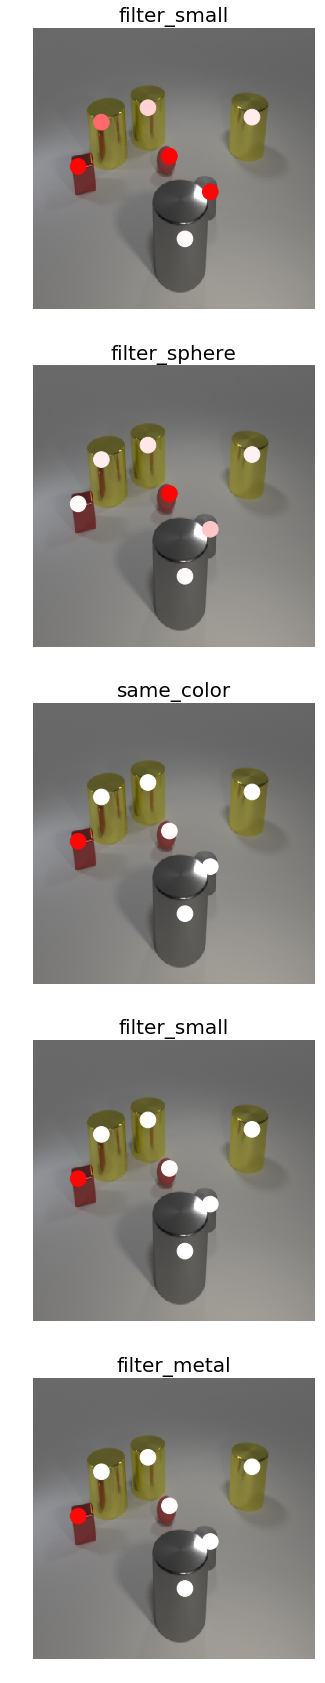

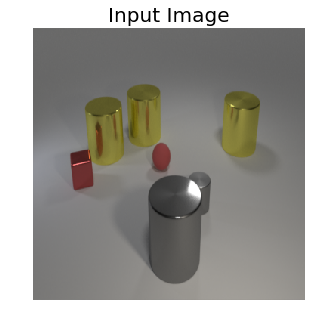

 Question: There is a small metal thing that is the same color as the tiny sphere ; what is its shape ?
 Predicted: cylinder; Answer: cube


In [ ]:
scores = []
total = 10000
cnt = 0
sz=6

for batch in val_loader:
    clear_output()
    
    answers, questions, gt_programs, gt_program_inputs, *batch_input = [todevice(x, device) for x in batch]
    answer_str = vocab['answer_idx_to_token'][answers[0].item()]
    image_idx = val_loader.idx_cache[0]
    annotation = orig_annotations[image_idx]
    objects_coord = val_loader.coord_cache[0]
    image_file = os.path.join(image_dir, annotation['image_filename'])
    img = plt.imread(image_file)
    programs, program_inputs = predict_david_program(questions, val_loader)
    predict_str, intermediates = model.forward_and_return_intermediates(programs, program_inputs, *batch_input)
    if not intermediates:
        continue
    if answer_str == predict_str:
        continue

    cnt += 1
    # =============== split into branches ================
    branches = []
    branch = []
    intermediates.append(None)
    for i in range(len(intermediates)):
        if intermediates[i] is None:
            if branch:
                branches.append(branch)
            branch = []
        else:
            branch.append(intermediates[i])
    # ---------------------------------
    if len(branches) == 3:
        branches[1], branches[2] = branches[2], branches[1]
        leg_len = max(len(branches[0]), len(branches[2]))
        l = leg_len+len(branches[1])
        fig, axs = plt.subplots(*T(3, l), squeeze=False, figsize=T(sz*l, sz*3))
        for i in range(3):
            for j in range(len(branches[i])):
                title, attn = branches[i][j]
                c = leg_len+j if i==1 else leg_len-len(branches[i])+j
                draw_at_coords(axs[T(i, c)], objects_coord, attn, img, title)
            for j in range(l):
                if (i!=1 and leg_len-len(branches[i])<=j<leg_len) or\
                    (i==1 and leg_len<=j<leg_len+len(branches[i])):
                    continue
                axs[T(i,j)].remove()
    # ---------------------------------
    else:
        l = max(len(b) for b in branches)
        fig, axs = plt.subplots(*T(len(branches), l), squeeze=False, figsize=T(sz*l, sz*len(branches)))
        for i in range(len(branches)):
            for j in range(len(branches[i])):
                title, attn = branches[i][j]
                draw_at_coords(axs[T(i, l-len(branches[i])+j)], objects_coord, attn, img, title)
            for j in range(l-len(branches[i])):
                axs[T(i,j)].remove()
    # ======================================================
    

    plt.pause(0.0001) # real-time show
    print("="*50)
    _, ax = plt.subplots(figsize=(5,5))
    display_helper(ax, img, 'Input Image')
    plt.pause(0.0001)
    print(" Question: %s ?\n Predicted: %s; Answer: %s" % 
          (question_to_str(questions, vocab), predict_str, answer_str))
    
    score = input_score("%d/%d. Please select one score from: 1(unclear), 2(somewhat unclear), 3(mostly clear) and 4(clear)"\
                  % (cnt, total))
    scores.append(score)
    if cnt >= total:
        break

clear_output()
print("mean score of %d samples: %.3f" % (total, np.mean(scores)))
worker = input("Thank you! Please input your name:")
filename = './data/human_eval_results.txt'
with open(filename, 'a') as f:
    content = '[Task1] Time:[%s] Worker: %s. Samples: %d. Mean score: %.3f\n' %\
        (datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), worker, total, np.mean(scores))
    f.write(content)
    print("Write into %s" % filename)
print("All Finshed!")

# nice sample index(no shuffle): 90, 96, 112, 114, 129, 134, 174, 
# concise scene: 61~70, 121~130

## show original image of target index

In [ ]:
target = 111
i = 0
from IPython.display import Image, display

for batch in val_loader.generator():
    i += 1
    if i != target:
        continue
    answers, questions, gt_programs, gt_program_inputs, *batch_input = [todevice(x, device) for x in batch]
    image_idx = val_loader.idx_cache[0]
    annotation = val_loader.orig_annotations[image_idx]
    objects_coord = [obj['pixel_coords'] for obj in annotation['objects']]
    image_file = os.path.join(image_dir, annotation['image_filename'])
    break
Image(filename=image_file)